# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Fall 2019

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [1]:
import cv2
import numpy as np
import math

from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# images location
#im1 = './images/input/frames/f0001.jpg'
im1 = './images/input/frames/f0450.jpg'
im2 = './images/input/frames/f0270.jpg'

# Load an color image in grayscale
im1_r = cv2.imread(im1)
right = cv2.cvtColor(im1_r, cv2.COLOR_BGR2RGB)



im2_r = cv2.imread(im2)
left = cv2.cvtColor(im2_r, cv2.COLOR_BGR2RGB)

# print(im1.shape)
# print(im2.shape)

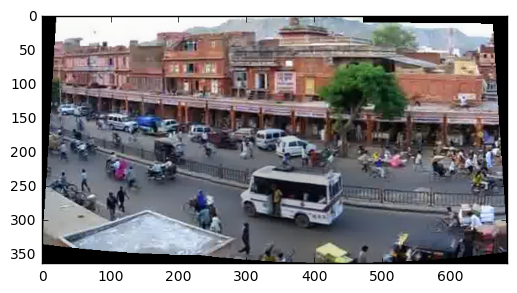

In [3]:
# import the necessary packages
#from imutils import paths
import argparse
#import imutils



images = []
images.append(left)
images.append(right)


#cv2.Stitcher_create()
stitcher = cv2.createStitcher() #if imutils.is_cv3() else cv2.Stitcher_create()
(ret, pano) = stitcher.stitch(images)
plt.imshow(pano)

In [4]:
def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)
        

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 1  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            pts11 = pts1
            pts22 = pts2
            in_idx = ok_t
    
    #print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [5]:
## Homography Maps corresponding point of two images.

In [6]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    
    H,W = pts1.shape
    X = np.zeros((W*2, 9))
    
    
    
    for j in range(W):
        pix1 = pts1[:, j]
        pix2 = pts2[:, j]
        u,v = pix1[0], pix1[1]
        u1,v1 = pix2[0], pix2[1]  
        
        # Calculate Direct linear transform of points (brute force)
        
        X[2*j,:] = np.array([-u, -v, -1, 0, 0, 0, u*u1, v*u1, u1])              
        X[2*j+1, :] = np.array([0, 0, 0, -u, -v, -1, u*v1, v*v1, v1])
    
    #compute candidate matches
    _,_,V = np.linalg.svd(X)
    

    
    # Homography parameters
    h = V[V.shape[0]-1,:]  # Select last row
    Matrix = np.reshape(h, (3,3))
    
    #print(Matrix[0,:])
    
        
    
    return Matrix
   
    #raise Exception("TODO in computeHomography() not implemented")


In [7]:
H  = auto_homography(right,left, computeHomography)
print(H)



[[ 3.99578121e-03 -2.13966223e-04  9.97797727e-01]
 [-8.54397239e-05  4.60560340e-03  6.58674823e-02]
 [-1.89008146e-06 -1.04164271e-08  4.89284885e-03]]


### Draw Red Rectangle on image using Homography

(-0.5, 479.5, 359.5, -0.5)

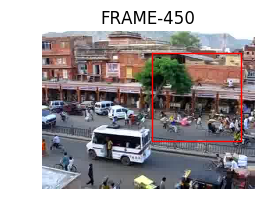

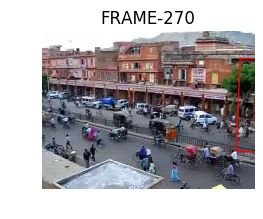

In [8]:
r1 = np.array([250, 450, 450, 250, 250])
r2 = np.array([50, 50, 250, 250, 50])
v = np.ones(5)
rec = np.array([r1, r2, v])



rec_pro = np.dot(H, rec)
rec_pro = rec_pro / rec_pro[-1] # Noramlized



fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 2, 1)
#ax1.plot(rec_pro[0], rec_pro[1], 'r')
ax1.plot(r1, r2, 'r')
plt.title('FRAME-450')
plt.imshow(right)

plt.axis('off')


fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 2, 1)
ax2.plot(rec_pro[0], rec_pro[1], 'r')
#ax1.plot(r1, r2, 'r')
plt.title('FRAME-270')

plt.imshow(left)
plt.axis('off')




## Identity Matrix

In [ ]:
Tx = 0
Ty = 0
refH = np.array([
        [1,0,Tx],
        [0,1,Ty],
        [0,0,1]]
               
        )/255


In [ ]:
## Example usage of cv2.warpPerspective
## Tips: 
##      1.For reference frame, you may just use identity matrix for the transformation.
##      2.To avoid some pixels being mapped to negative locations, you may want to apply translations first.
projectedWidth = 1600
projectedHeight = 500


t = np.float32([[1,0,300], [0,1,11]])

#im2 = cv2.warpAffine(im2, translation_matrix, (num_cols, num_rows))

projectedSource = cv2.warpPerspective(left, refH, (projectedWidth, projectedHeight))
projectedSource = cv2.warpAffine(projectedSource, t, (projectedWidth, projectedHeight))

projectedReference = cv2.warpPerspective(right, H, (projectedWidth, projectedHeight))
projectedReference = cv2.warpAffine(projectedReference, t, (projectedWidth, projectedHeight))



## Example usage of utils.blendImages
blendedOutput = utils.blendImages(projectedSource, projectedReference)

plt.figure(figsize=(60,10))
#blendedOutput= cv2.cvtColor(blendedOutput, cv2.COLOR_BGR2RGB)


plt.imshow(blendedOutput)


### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



## This Ref Homography  matrix is used to translate to images

* This requies tuning

* Translate Matrix refH is [ [1, 0, Tx], [0,1,Ty], [0,0,1]]

* Tune Tx and Ty accordingly

In [ ]:
import cv2
import numpy as np

Tx = 600
Ty = 60
refH = np.array([
        [1,0,Tx],
        [0,1,Ty],
        [0,0,1]]
               
        )/255

In [ ]:
master_frames =[90, 270, 450, 630, 810]
reference_frame = 450
reference_idx = master_frames.index(reference_frame)


im1 = cv2.imread('./images/input/frames/f0090.jpg')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

im2 = cv2.imread('./images/input/frames/f0270.jpg')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)


im3 = cv2.imread('./images/input/frames/f0450.jpg')
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)

im4 = cv2.imread('./images/input/frames/f0630.jpg')
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)

im5 = cv2.imread('./images/input/frames/f0810.jpg')
im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)

H1 = auto_homography(im2,im3, computeHomography)
H2 = auto_homography(im1,im2, computeHomography)
leftSide = np.matmul(H1, H2)

H3 = auto_homography(im4,im3, computeHomography)
H4 = auto_homography(im5,im4, computeHomography)
rightSide = np.matmul(H3, H4)


## Create the projection and Translate the perspective images

* images are mapped pixel by pixel onto the final cnavas with mapImage() with spcific overlap order.

In [ ]:
# maping image pixel by pixel to overlap from left to right
def mapImage(im, im2, im3, im4, im5):
    ''' map each image onto the canvas'''
    
    ImageOut = np.zeros((600,1600,3))
    h, w, _ = im.shape
    

    for r in range(h):
        for c in range(w):
            ImageOut[r,c] = im2[r,c]
    for r in range(h):
        for c in range(w):
            if ImageOut[r,c,0] == 0 and ImageOut[r,c,1] == 0 and ImageOut[r,c,2] == 0:
                ImageOut[r,c] = im3[r,c]
    for r in range(h):
        for c in range(w):
            if ImageOut[r,c,0] == 0 and ImageOut[r,c,1] == 0 and ImageOut[r,c,2] == 0:
                ImageOut[r,c] = im[r][c]
    for r in range(h):
        for c in range(w):
            if ImageOut[r,c,0] == 0 and ImageOut[r,c,1] == 0 and ImageOut[r,c,2] == 0:
                ImageOut[r,c] = im4[r,c]
    for r in range(h):
        for c in range(w):
            if ImageOut[r,c,0] == 0 and ImageOut[r,c,1] == 0 and ImageOut[r,c,2] == 0:
                ImageOut[r,c] = im5[r,c]
    return ImageOut/255

      

def createProjection(f450, h270, f270, left, f90, h630, f630, right, f810):
    '''warp perspective and translation of each frame'''
    
    
    t = np.float32([[1,0,60], [0,1,11]]) # Final traslation of images (requires tuning)
    
    projected2 = cv2.warpPerspective(f90, refH.dot(left), (1600, 600)) 
    projected2 = cv2.warpAffine(projected2, t, (projectedWidth, projectedHeight))

    projected3 = cv2.warpPerspective(f270, refH.dot(h270), (1600, 600))
    projected3 = cv2.warpAffine(projected3, t, (projectedWidth, projectedHeight))

    projected4 = cv2.warpPerspective(f630, refH.dot(h630), (1600, 600))
    projected4 = cv2.warpAffine(projected4, t, (projectedWidth, projectedHeight))

    projected5 = cv2.warpPerspective(f810, refH.dot(right), (1600, 600))
    projected5 = cv2.warpAffine(projected5, t, (projectedWidth, projectedHeight))

    
    projected1 = cv2.warpPerspective(f450, refH, (1600,600))
    projected1 = cv2.warpAffine(projected1, t, (projectedWidth, projectedHeight))

    
   
    return mapImage( projected1,  projected2, projected3, projected4,  projected5)
    


In [ ]:
plt.figure(figsize=(60,10))
plt.imshow(createProjection(im3, H1, im2, leftSide, im1, H3, im4, rightSide, im5))

### Part 3: Map the video to the reference plane

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor



In [ ]:
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [ ]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [ ]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [ ]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0


In [ ]:
## Example usage of utils.projectImage

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
#pastH_collect = pastHomographies

referenceFrameIndex = 450

In [7]:
# Code from UIUC

def transformImage(frames, sourceFrameIndex, referenceFrameIndex,
                   pastHomographies, xrange, yrange, auto_H_func,
                   homography_func, normalization_func):
    '''
    Input:
        - frames: 4D array of frames
        - sourceFrameIndex: index of the frame to be projected
        - referenceFrameIndex: index of the frame to be projected to
        - pastHomographies: 2D cell array caching previously computed
          homographies from every frame to every other frame
        - xrange, yrange: dimensions of the output image
    Output:
        - homography: homography from source frame to reference frame
        - imageTransform: projected source frame with dimensions (xrange, yrange)
    '''

    if pastHomographies[sourceFrameIndex, referenceFrameIndex].any():
        homography = pastHomographies[sourceFrameIndex, referenceFrameIndex]
    else:
        homography = auto_H_func(frames[sourceFrameIndex], frames[referenceFrameIndex],
                                 homography_func, normalization_func)
        pastHomographies[sourceFrameIndex, referenceFrameIndex] = homography.astype(np.float32)

    sourceFrame = frames[sourceFrameIndex]

    sourceFrame_corners = utils.get_img_corners(sourceFrame)
    sourceFrame_corners_tranform_corners = cv2.perspectiveTransform(sourceFrame_corners, homography)
    canvas_corners = np.array([[0., 0.], [xrange, 0.], [yrange, xrange], [0., yrange]])

    corners = np.concatenate((np.squeeze(sourceFrame_corners_tranform_corners, axis=1), canvas_corners))
    [x_min, y_min] = np.ceil(corners.min(axis=0)).astype(int)
    [x_max, y_max] = np.ceil(corners.max(axis=0)).astype(int)

    # Translation matrix
    t = [-x_min, -y_min]
    H_t = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]], dtype=np.float32)

    # Dot product of translation matrix and homography
    T = H_t.dot(homography)

    projectedImage = cv2.warpPerspective((sourceFrame*255).astype(np.uint8), T, (xrange, yrange))

    return homography, projectedImage, np.array([x_min, y_min])

In [8]:
# Code from UIUC

def getFrameProjection(frames, sourceFrameIndex, referenceFrameIndex, pastHomographies, 
                       originTranslation, x, y , auto_H_func = None, 
                       homography_func = None, normalization_func = None):
        
    numFrames = frames.shape[0]

    _, referenceTransform, ref_origin_coord = transformImage(frames, referenceFrameIndex, referenceFrameIndex, pastHomographies, x, y, auto_H_func, homography_func, normalization_func)
    _, sourceTransform, src_origin_coord    = transformImage(frames, sourceFrameIndex, referenceFrameIndex, pastHomographies, x, y, auto_H_func, homography_func, normalization_func)
    #_, err = utils.computeOverlap(sourceTransform, src_origin_coord, referenceTransform, ref_origin_coord, overlapThreshold)
    originTranslations[sourceFrameIndex] = src_origin_coord

    x_min, y_min = originTranslations[0]
    # Translation matrix
    t = [-x_min, -y_min]
    H_t = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]], dtype=np.float32)

    # Dot product of translation matrix and homography
    pastHomographies[sourceFrameIndex, referenceFrameIndex] = H_t.dot(pastHomographies[sourceFrameIndex, referenceFrameIndex])
    #print(pastHomographies[sourceFrameIndex, referenceFrameIndex])
    projectedImage = cv2.warpPerspective((frames[sourceFrameIndex]*255).astype(np.uint8),
                                         pastHomographies[sourceFrameIndex, referenceFrameIndex],
                                         (x, y))
    
    return projectedImage, pastHomographies, originTranslation

# Map between key frames (0-90-270) -450- (630-810-899)

##  Map Left side image to ref plane
## Map right side images to ref plane

In [ ]:
t_frames = np.zeros((900, 600, 1600, 3), dtype=np.float32)
keyFrameIndex90 = 90
keyFrameIndex270 = 270

refFrameIndex450 = 450

keyFrameIndex630 = 630
keyFrameIndex810 = 810

count = 0


x = 1600
y = 600

#left side

for i in range(0,450):
    
    #left side events
    projectedSource, pastH, _ = getFrameProjection(frames, i, refFrameIndex450,
                                                            pastHomographies, originTranslations, x, y,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    try:
        if projectedSource.shape[0] <= 0:
            print(empty)
            continue
        else:
            #projectedSource = projectedSource/255
            #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(i), projectedSource)
            t_frames[i] = projectedSource/255
            
            
    except:
        continue 
        

    projectedSource,_, _ = getFrameProjection(frames, 899 - i, refFrameIndex450,
                                                            pastHomographies, originTranslations, x, y,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    try:
        if projectedSource.shape[0] <= 0:
            print(empty)
            continue
        else:
            #projectedSource = projectedSource/255
            #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(i), projectedSource)
            t_frames[899-i] = projectedSource/255
            
    except:
        continue 
        

        
# for i in range(270,450):
    
#     #right side events
#     projectedSource, _, _ = getFrameProjection(frames, i, refFrameIndex450,
#                                                             pastHomographies, originTranslations, x, y,
#                                                             auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
#     try:
#         if projectedSource.shape[0] <= 0:
#             print(empty)
#             continue
#         else:
#             #projectedSource = projectedSource/255
#             #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(899-i), projectedSource)
#             t_frames[i] = projectedSource/255
            
#     except:
#         continue
        
#     projectedSource,_, _ = getFrameProjection(frames, 629 - count, refFrameIndex450,
#                                                             pastHomographies, originTranslations, x, y,
#                                                             auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
#     count+=1
#     try:
#         if projectedSource.shape[0] <= 0:
#             print(empty)
#             continue
#         else:
#             #projectedSource = projectedSource/255
#             #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(899-i), projectedSource)
#             t_frames[630-count] = projectedSource/255
            
#     except:
#         continue



In [ ]:
for index, frame in enumerate(t_frames):
    cv2.imwrite('./projected_images/a{:04d}.jpg'.format(index), cv2.cvtColor(frame*200, cv2.COLOR_RGB2BGR))


### Saving Out puts for next steps

In [ ]:

#np.save('t_frames.npy', t_frames)

In [ ]:
import joblib


In [ ]:
joblib.dump(pastHomographies, 'pastH.sav')

In [ ]:
utils.imageFolder2mpeg('projected_images', fps=30)
plt.imshow(t_frames[0])

### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

## Memory issues with this part so I am loading a saved image_array from previous part

* cut number of mages in half to avoid memory issues

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# cut the total amount of frames in half
print('Loading...')
#frame_matrix = np.load("t_frames.npy")
print('Done Loading')




# print('Down sizing')

# i = 0
# for index, frame in enumerate(t_frames):
#     if index%2 == 0:
#         frames[i] = frame
#         i+=1
#     else: continue


#manage memory
h, w = t_frames[0].shape[0], t_frames[0].shape[1]
background = np.zeros((h,w,3,len(t_frames)))
print('Fill NaN')
background.fill(np.nan)



print('NonZero matrix')
frame,x,y,c = np.nonzero(t_frames)

print("Init Cal median")
background[x,y,c,frame] = t_frames[frame,x,y,c]
print('Get Median')

#manage memory 
del t_frames

print("calulate background image")
background_image = np.nanmedian(background,axis=3)

np.save('background.npy', background_image)
plt.imshow(background_image)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(background_image)

### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

## Using saved background image from Part 4

In [ ]:
bg_img = np.load("background.npy")
plt.imshow(bg_img)

## Background image has to be normalized because of my previous encoding type

* cv2.normalize(bg_img,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib


images = "background_images"

if not os.path.exists(images):
    os.makedirs(images)
    
print('Done...creat projected images')
projected_images = np.zeros((900,360,480,3))

print("project and aligning frames")
for i in range(0, 900):
   

    H = pastHomographies[i][450]
    #print(H)
    Ht = np.linalg.inv(H)
    
    #normalize backgroung image
    background_image = cv2.normalize(bg_img,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)
    
    projectedSource = cv2.warpPerspective(background_image, Ht, (480, 360))
   
    
    projected_images[i,:,:,:] = projectedSource 
    
    cv2.imwrite(images + '/a{:04d}.jpg'.format(i), cv2.cvtColor(projectedSource, cv2.COLOR_RGB2BGR))
    


## Convert Background to Movie

In [ ]:
utils.imageFolder2mpeg(images, output_path="./background_movie.mpeg", fps=30)

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [ ]:
import os
import cv2
import numpy as np


foreground_images = "foreground_images"
if not os.path.exists(foreground_images):
    os.makedirs(foreground_images)

for i in range(0, 900):
    frame = cv2.normalize(frames[i],None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)
    dif_foreground = frame - (projected_images[i])
    cv2.imwrite(foreground_images + '/a{:04d}.jpg'.format(i), dif_foreground*1.5)
    
utils.imageFolder2mpeg(foreground_images, output_path="./foreground_movie.mpeg", fps=30)

## Bells and whistles

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [ ]:
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [ ]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [ ]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [ ]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0


In [ ]:
## Example usage of utils.projectImage

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
#pastH_collect = pastHomographies 

referenceFrameIndex = 450

## Remove Camera Shake by mapping between more key Frames --This will yeld a smoother video

* Map from 0-270-450-630-900

In [ ]:
t_frames = np.zeros((900, 600, 1600, 3), dtype=np.float32)
keyFrameIndex90 = 90
keyFrameIndex270 = 270

refFrameIndex450 = 450

keyFrameIndex630 = 630
keyFrameIndex810 = 810

count = 0


x = 1600
y = 600

#left side

for i in range(0,270):
    
    #left side events
    projectedSource, pastH, _ = getFrameProjection(frames, i, keyFrameIndex270,
                                                            pastHomographies, originTranslations, x, y,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    try:
        if projectedSource.shape[0] <= 0:
            print(empty)
            continue
        else:
            #projectedSource = projectedSource/255
            #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(i), projectedSource)
            t_frames[i] = projectedSource/255
            
            
    except:
        continue 
        

    projectedSource,_, _ = getFrameProjection(frames, 899 - i, keyFrameIndex630,
                                                            pastHomographies, originTranslations, x, y,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    try:
        if projectedSource.shape[0] <= 0:
            print(empty)
            continue
        else:
            #projectedSource = projectedSource/255
            #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(i), projectedSource)
            t_frames[899-i] = projectedSource/255
            
    except:
        continue 
        

        
for i in range(270,450):
    
    #right side events
    projectedSource, _, _ = getFrameProjection(frames, i, refFrameIndex450,
                                                            pastHomographies, originTranslations, x, y,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    try:
        if projectedSource.shape[0] <= 0:
            print(empty)
            continue
        else:
            #projectedSource = projectedSource/255
            #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(899-i), projectedSource)
            t_frames[i] = projectedSource/255
            
    except:
        continue
        
    projectedSource,_, _ = getFrameProjection(frames, 629 - count, refFrameIndex450,
                                                            pastHomographies, originTranslations, x, y,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    count+=1
    try:
        if projectedSource.shape[0] <= 0:
            print(empty)
            continue
        else:
            #projectedSource = projectedSource/255
            #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(899-i), projectedSource)
            t_frames[629-count] = projectedSource/255
            
    except:
        continue


In [ ]:
for index, frame in enumerate(t_frames):
    cv2.imwrite('./myProjected_images/my{:04d}.jpg'.format(index), cv2.cvtColor(frame*200, cv2.COLOR_RGB2BGR))

In [ ]:
utils.imageFolder2mpeg('Myprojected_images', fps=30)
plt.imshow(t_frames[0])

##  Smoothing Image

In [ ]:
# images location
#im1 = './images/input/frames/f0001.jpg'
im1 = './images/input/frames/f0450.jpg'
im2 = './images/input/frames/f0270.jpg'

# Load an color image in grayscale
im1_r = cv2.imread(im1)
right = cv2.cvtColor(im1_r, cv2.COLOR_BGR2RGB)



im2_r = cv2.imread(im2)
left = cv2.cvtColor(im2_r, cv2.COLOR_BGR2RGB)


images = []
images.append(left)
images.append(right)


#cv2.Stitcher_create()
stitcher = cv2.createStitcher() #if imutils.is_cv3() else cv2.Stitcher_create()
(ret, pano) = stitcher.stitch(images)
plt.imshow(pano)

## My Video

### Steps

* Take a panorama Video with my camera
* Convert video to series of images using utils.video2imageFolder() function
* Run Part-3 process
* Save My frames in images folder

In [3]:
#path = 'C:\\Users\\super\\Desktop\\CS-445 - Computational Photo\\project 5 - starter package\\mp5\\images\\input\\my_other_frames'
#utils.video2imageFolder('myOtherVid.mp4', path)

In [ ]:
from PIL import Image
import glob

## Resize and rotate my images

In [ ]:
def crop_image(img,tol=0):
    # img is 2D image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

In [ ]:
newImage_dir = 'C:/Users/super/Desktop/CS-445 - Computational Photo/project 5 - starter package/mp5/images/input/other_rotated_frames/f'
#newImage_dir1 = 'C:/Users/super/Desktop/CS-445 - Computational Photo/project 5 - starter package/mp5/images/input/my_new_frames/f'

i = 0
for filename in glob.glob('C:/Users/super/Desktop/CS-445 - Computational Photo/project 5 - starter package/mp5/images/input/my_other_frames/*.jpg'):
    image = Image.open(filename).rotate(180)
    #image = img.resize((470,330))
    image.save('{}{:04d}{}'. format(newImage_dir, i+1,'.jpg' ))
    i+=1

  
    

In [ ]:
# newImage_dir1 = 'C:/Users/super/Desktop/CS-445 - Computational Photo/project 5 - starter package/mp5/images/input/my_new_frames/f'


# for filename in glob.glob('C:/Users/super/Desktop/CS-445 - Computational Photo/project 5 - starter package/mp5/images/input/rotated_frames/*.jpg'):
#     image = Image.open(filename)
#     image = img.resize((330,530))
#     image = crop_image(image, 80)
#     image.save('{}{:04d}{}'. format(newImage_dir1, i+1,'.jpg' ))
#     i+=1

    

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [10]:
dir_frames = 'images/input/my_other_frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [11]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))


In [12]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape


frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)
frames = np.zeros((frameCount, 720, 1280, frameChannels),dtype=np.float32)

In [13]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0

In [14]:
## Example usage of utils.projectImage

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
#pastH_collect = pastHomographies

referenceFrameIndex316 = 316

In [15]:
t_frames = np.zeros((632, 800, 2000, 3), dtype=np.float32)


count = 0


x = 2000
y = 800

#left side

for i in range(0,250):
    
    #left side events
    projectedSource, pastH, _ = getFrameProjection(frames, i, referenceFrameIndex316,
                                                            pastHomographies, originTranslations, x, y,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    try:
        if projectedSource.shape[0] <= 0:
            print(empty)
            continue
        else:
            #projectedSource = projectedSource/255
            #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(i), projectedSource)
            t_frames[i] = projectedSource/255
            
            
    except:
        continue 
        

    projectedSource,_, _ = getFrameProjection(frames, 631 - i, referenceFrameIndex316,
                                                            pastHomographies, originTranslations, x, y,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    try:
        if projectedSource.shape[0] <= 0:
            print(empty)
            continue
        else:
            #projectedSource = projectedSource/255
            #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(i), projectedSource)
            t_frames[631-i] = projectedSource/255
            
    except:
        continue 
        

        
# for i in range(270,450):
    
#     #right side events
#     projectedSource, _, _ = getFrameProjection(frames, i, refFrameIndex450,
#                                                             pastHomographies, originTranslations, x, y,
#                                                             auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
#     try:
#         if projectedSource.shape[0] <= 0:
#             print(empty)
#             continue
#         else:
#             #projectedSource = projectedSource/255
#             #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(899-i), projectedSource)
#             t_frames[i] = projectedSource/255
            
#     except:
#         continue
        
#     projectedSource,_, _ = getFrameProjection(frames, 629 - count, refFrameIndex450,
#                                                             pastHomographies, originTranslations, x, y,
#                                                             auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
#     count+=1
#     try:
#         if projectedSource.shape[0] <= 0:
#             print(empty)
#             continue
#         else:
#             #projectedSource = projectedSource/255
#             #cv2.imwrite('./projected_images/a{:04d}.jpg'.format(899-i), projectedSource)
#             t_frames[629-count] = projectedSource/255
            
#     except:
#         continue

In [16]:
for index, frame in enumerate(t_frames):
    cv2.imwrite('./myOtherProjected_images/f{:04d}.jpg'.format(index), cv2.cvtColor(frame*200, cv2.COLOR_RGB2BGR))

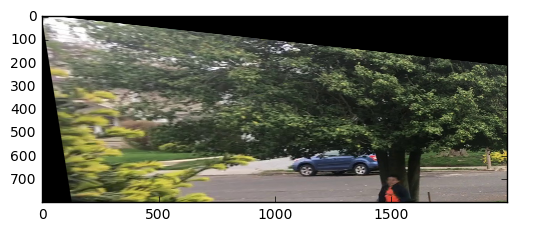

In [17]:
utils.imageFolder2mpeg('myOtherProjected_images', fps=30)
plt.imshow(t_frames[0])